In [2]:
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
import time
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from collections import defaultdict
import itertools
from urllib.parse import parse_qs
import glob
import matplotlib.pylab as plt
from collections import Counter
import collections
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
import csv

In [ ]:
def get_job_links_page(page):
    base_url = "https://www.indeed.com/jobs?"
    params = {'q': 'data scientist', 
             'l': 'Boulder, CO'}
    
    #we've downloaded job listings in Denver and Boulder for the following search terms: 
    #data analyst, business analyst and data scientist 
    # start = "https://www.indeed.com/jobs?q=Data+Scientist&l=Denver%2C+CO"
    # use a fake header
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/67.0.3396.87 Safari/537.36'}
    params['start'] = 10 * (page-1)

    page = requests.get(base_url, params=params, headers=headers)
    # test = requests.get(start, headers=headers)
    
    soup = BeautifulSoup(page.text, "html.parser")
    links = soup.find_all("a")
    
    # build a list of links
    some_links = []

    for l in links:
        try:
            hyperlink = l.attrs.get('href')
            if "/rc/clk?" in hyperlink:
                some_links.append(l.attrs.get('href'))
        except:
            pass
    
    job_links = ["https://www.indeed.com{}".format(x)
             for x in some_links
             ]
    
    return job_links


In [ ]:
links = [get_job_links_page(x) for x in tqdm(range(1, 100))] # getting a link for 39 pages 

In [ ]:
len(links)

In [ ]:
merged = list(itertools.chain(*links))
len(merged)
merged[0] # getting a link for 39 pages 

In [ ]:
def get_filename_from_url(some_url):
    parsed = parse_qs(some_url)
    fccid =  parsed.get('fccid')[0]
    other_id = parsed.get('https://www.indeed.com/rc/clk?jk')[0]
    return fccid+other_id+ ".html"

In [ ]:
get_filename_from_url(merged[0]) # file name for each html file

In [ ]:
len(set([get_filename_from_url(x) for x in merged])) # the total number of html files(jobs) parsed and saved locally. 

In [ ]:
#downloading each html file as a soup object
def download_job_page(link):
    save_name = get_filename_from_url(link)
    
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/67.0.3396.87 Safari/537.36'}
    test = requests.get(link, headers=headers)
    soup = BeautifulSoup(test.text, "html.parser")
    
    with open('data_scienceBoulder_{}'.format(save_name), 'w') as f:
        f.write(str(soup))

In [ ]:
for link in tqdm(merged):
    try:
        download_job_page(link)
    except Exception as e:
        print(str(e), link)
    finally:
        time.sleep(1)


In [3]:
html = glob.glob('*.html')
len(html) # the total number of html files(jobs) parsed and saved locally. 

1775

In [4]:
html_divs = []
columns = ['company', 'location', 'jobtitle', 'job_summary', 'type']
jobs_df = pd.DataFrame(index=html, columns=columns)

for html_file in html:
    with open(html_file, 'r',encoding="ISO-8859-1") as f:
        _data = BeautifulSoup(f.read(), "html.parser")
        try:
            has_span_job_summary = _data.find("span", id="job_summary").get_text()
            html_divs.append(has_span_job_summary)
            jobs_df['company'][html_file] = _data.find("span", "company").get_text()
        except:
            print('The company field does not exist in: ' + html_file)
        try:
            jobs_df['location'][html_file] = _data.find("span", "location").get_text()
        except:
            print('The location field does not exist in: ' + html_file)
        try:
            jobs_df['jobtitle'][html_file] = _data.find("b", "jobtitle").get_text()
        except:
            print('The jobtitle field does not exist in: ' + html_file)
        try:
            jobs_df['job_summary'][html_file] = _data.find("span", id="job_summary").get_text()
        except:
            print('The job summary field does not exist in: ' + html_file)
        
len(html_divs) # total numbers of job postings saved locally. 

The company field does not exist in: data_anaBoulder_5c2fb4d168d95f8e30dbdc723d33fa73.html
The location field does not exist in: data_anaBoulder_5c2fb4d168d95f8e30dbdc723d33fa73.html
The jobtitle field does not exist in: data_anaBoulder_5c2fb4d168d95f8e30dbdc723d33fa73.html
The job summary field does not exist in: data_anaBoulder_5c2fb4d168d95f8e30dbdc723d33fa73.html
The company field does not exist in: data_anaBoulder_e370394a608927d2bdbafd2459667aad.html
The location field does not exist in: data_anaBoulder_e370394a608927d2bdbafd2459667aad.html
The jobtitle field does not exist in: data_anaBoulder_e370394a608927d2bdbafd2459667aad.html
The job summary field does not exist in: data_anaBoulder_e370394a608927d2bdbafd2459667aad.html
The company field does not exist in: data_analyst_2803441767d1ee9b995baf321d58e9c9.html
The location field does not exist in: data_analyst_2803441767d1ee9b995baf321d58e9c9.html
The jobtitle field does not exist in: data_analyst_2803441767d1ee9b995baf321d58e9c9

1763

In [5]:
jobs = pd.DataFrame(html_divs)
jobs.columns = ['job_summary']
jobs.head(10)

,job_summary
0,Come join a fast-paced technology organization...
1,Summary\nThe Business Intelligence Analyst is ...
2,Data Administrator\nFlexential stands for some...
3,The Institutional Planning & Analysis departme...
4,Location(s): CO - Denver; MN - Minneapolis\n\n...
5,"Perform business architecture, Human Resources..."
6,"Working as a member of Blue Moon Digital, Inc...."
7,"Dedicated to quality, innovation, engagement, ..."
8,Job Description\n\nRLH Revenue Team Overview:\...
9,Arcadis is looking for an experienced Manageme...


In [6]:
jobs.shape

(1763, 1)

In [7]:
df1=pd.read_csv('hacker_news.csv')
df1['company'] = ""
df1['location'] = ""
df1['jobtitle'] = ""
df1['type'] = ""
df1['partitions'] = 0
# del df1['source']
df1.rename(columns={'desc': 'job_summary'}, inplace=True)
df1 = df1.drop_duplicates()
for i, row in df1.iterrows():
    s=row['job_summary']
    sp = [x.strip() for x in s.split('|')]
    df1.loc[i,('partitions')] = len(sp)
    if len(sp) > 1:
        df1.loc[i,('company')] = sp[0]
    if len(sp) == 2:
        sp1 = sp[1].split('<p>')
        df1.loc[i,('location')] = sp1[0]
        sp2 = sp1[1].split(':')
        if len(sp2) == 1:
            df1.loc[i,('job_summary')] = sp1[1]
        if len(sp2) == 2:
            df1.loc[i,('jobtitle')] = sp2[0]
            df1.loc[i,('job_summary')] = sp2[1]
    if len(sp) == 3:
       df1.loc[i,('location')] = sp[1]
       df1.loc[i,('jobtitle')] = sp[1]
       df1.loc[i,('job_summary')] = sp[2]
    if len(sp) > 3:
       df1.loc[i,('location')] = sp[1] + ' ' + sp[2]
       df1.loc[i,('jobtitle')] = sp[1] + ' ' + sp[2]
       df1.loc[i,('job_summary')] = sp[-1]
    if len(sp) > 4:
       df1.loc[i,('type')] = ' '.join(sp[3:-1]) 

In [8]:
df1 = df1[['company', 'location', 'jobtitle', 'job_summary', 'type']]
all_jobs=pd.concat([df1,jobs_df])
all_jobs.head(5)

,company,location,jobtitle,job_summary,type
0,"Photofeeler (<a href=""https:&#x2F;&#x2F;www.ph...","Software Engineers, Marketing Roles","Software Engineers, Marketing Roles","REMOTE or Onsite near Boulder, CO<p>If you wer...",
1,"Q-Branch Labs (<a href=""https:&#x2F;&#x2F;www....","Marketing Director, Hardware Product Manager, ...","Marketing Director, Hardware Product Manager, ...",£50-75K + equity<p>Join a team helping to prot...,London ONSITE
2,,,,"Worldwide, REMOTE, full time or part time -- 1...",
3,Lendable,"Senior Software Engineers, Senior Devops Engin...","Senior Software Engineers, Senior Devops Engin...","<p><a href=""https:&#x2F;&#x2F;www.lendable.co....",Full Time Onsite Salary: £60k-£80k
4,"Gambit Research Ltd (<a href=""http:&#x2F;&#x2F...","London, UK ONSITE","London, UK ONSITE",£40-80k + Bonus<p>Gambit Research specialises ...,


In [9]:
all_jobs.shape 

(4292, 5)

In [17]:
def load_skills_list():
    skills = pd.read_csv('skill_phrases_purged_JBM.csv', encoding="ISO-8859-1")
    skills.columns = ['skill_name']
    skills['skill_name'] = skills.skill_name.map(lambda x:x.lower().strip())
    return skills.skill_name.tolist()

In [18]:
def load_skills_df():# the macro enabled excel file. 
    skills = pd.read_csv('skill_phrases_purged-JBM.csv', usecols=['Skill Name', 'I Have It']).fillna(False)
    tokenizer = RegexpTokenizer(r'[a-zA-Z0-9#+-]+')
    skills['WL'] = [tokenizer.tokenize(skill_phrase) for skill_phrase in skills['Skill Name']]
    return skills

In [22]:
len(skills)

154

In [23]:
list_of_skills = load_skills_list()
skills = load_skills_df()

In [24]:
#make a big string of all job descriptions
try:
    job_string = " ".join([str(x) for x in all_jobs.job_summary.tolist()])
except:
    job_string = " "
    
job_tokens = nltk.word_tokenize(job_string)  
job_tokens = [word for word in job_tokens if len(word) >= 1] # remove space 
job_tokens = [word for word in job_tokens if not word in stop_words] # remove english language stop words 
job_tokens = [word.lower().strip() for word in job_tokens if not word in string.punctuation]


assert(type(job_tokens) == list)

filtered = Counter([x for x in job_tokens if x in list_of_skills])

In [25]:
filtered.most_common(20) # looking across skill frequency for all jobs, one way to do it

[('software', 2773),
 ('research', 2274),
 ('analytics', 1221),
 ('python', 875),
 ('sql', 776),
 ('access', 763),
 ('leadership', 758),
 ('developer', 621),
 ('database', 571),
 ('programming', 541),
 ('react', 514),
 ('aws', 454),
 ('social', 417),
 ('bi', 401),
 ('java', 389),
 ('hardware', 388),
 ('javascript', 386),
 ('agile', 384),
 ('backend', 345),
 ('server', 282)]

In [26]:
def get_matching_skills_for_search_kw(search_term, dataframe_name, load_skills_list):

    matches = defaultdict(int)

    for index, row in dataframe_name.iterrows():
        job_desc = row.job_summary # local specificity 
        if type(job_desc) == str:
            job_tokens = nltk.word_tokenize(job_desc)
            job_tokens = [word for word in job_tokens if len(word) >= 2] # remove space 
            job_tokens = [word for word in job_tokens if not word in stop_words] # remove english language stop words 
            job_tokens = [word.lower().strip() for word in job_tokens if not word in string.punctuation ] 

            if search_term in job_tokens:
                for skill in list_of_skills:
                    if (skill in job_tokens):
                        matches[skill] += 1

    return Counter(matches)

In [27]:
LIST_OF_QUERIES = ['excel','vba','python','sql','javascript','java'] 

all_matches =  { query: get_matching_skills_for_search_kw(query, 
                                                all_jobs, 
                                                list_of_skills) 
               for query in LIST_OF_QUERIES  }

In [32]:
all_matches

{'excel': Counter({'a/b': 3,
          'access': 211,
          'accessibility': 10,
          'adobe': 17,
          'agile': 39,
          'ai': 1,
          'analytics': 173,
          'apache': 5,
          'apis': 9,
          'ar': 2,
          'aws': 5,
          'backend': 2,
          'bi': 84,
          'bootstrap': 1,
          'bs': 24,
          'c++': 8,
          'cms': 4,
          'coding': 33,
          'crm': 23,
          'cs': 3,
          'css': 6,
          'css3': 5,
          'd3': 5,
          'database': 125,
          'developer': 18,
          'english': 20,
          'facebook': 12,
          'frameworks': 8,
          'graphs': 12,
          'hardware': 25,
          'html': 10,
          'html5': 5,
          'illustrator': 6,
          'instagram': 4,
          'java': 12,
          'javascript': 21,
          'jquery': 7,
          'json': 3,
          'leadership': 168,
          'linkedin': 5,
          'linux': 6,
          'math': 52,
          'me

In [28]:
all_match_df=pd.DataFrame(all_matches).fillna(0).astype(int)
all_match_df.head(5)

,excel,java,javascript,python,sql,vba
a/b,3,0,2,4,6,0
access,211,38,25,88,137,18
accessibility,10,3,5,6,7,2
adobe,17,1,16,5,18,0
agile,39,53,53,69,94,4


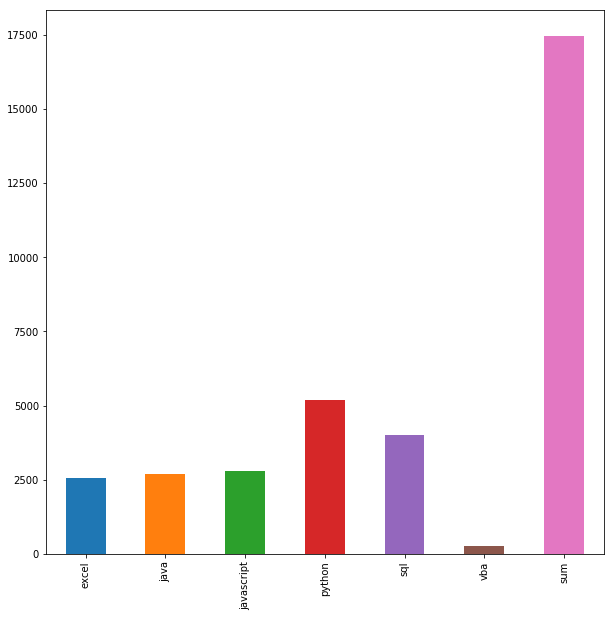

In [49]:
all_match_df.sum().plot(kind="bar",figsize=(10,10));

In [34]:
all_match_df['sum']=all_match_df.sum(axis=1).astype(int)

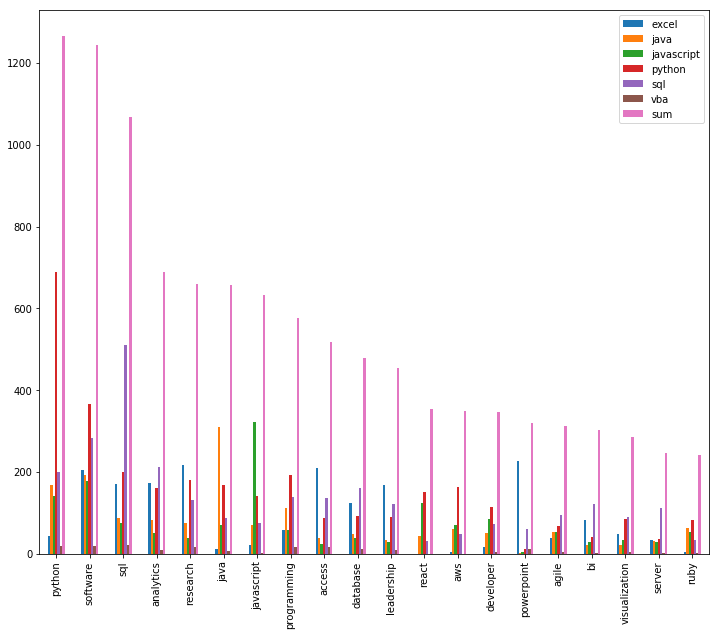

In [36]:
all_match_df.sort_values("sum", axis=0, ascending=False).head(20).plot(kind='bar',figsize=(12,10));

In [37]:
all_match_df.head(10)

,excel,java,javascript,python,sql,vba,sum
a/b,3,0,2,4,6,0,15
access,211,38,25,88,137,18,517
accessibility,10,3,5,6,7,2,33
adobe,17,1,16,5,18,0,57
agile,39,53,53,69,94,4,312
ai,1,16,6,37,9,0,69
analytics,173,82,52,160,213,10,690
android,0,45,25,47,15,0,132
angular,0,17,23,24,12,0,76
angularjs,0,7,16,15,4,0,42


In [ ]:
# colors = list("rgbcmyk")
# fig1, ax1 = plt.subplots()
# fig1.set_size_inches(18,10)

# for data_dict in all_matches.values():
# x = data_dict.keys()
# y = data_dict.values()
# plt.bar(x,y,color=colors.pop())

# plt.legend(all_matches.keys())
# plt.xticks([])
# plt.show()

In [ ]:
# for skill, c in all_matches.items():
# most_common = c.most_common(20)
# print(skill, "SUMMARY:")
# print('~~~~~~~~~~~~~~~~~~')
# for item, freq in most_common:
#     print(item, "+" * (freq//10))
# print()

In [ ]:
# for skill, c in all_matches.items():
# most_common = c.most_common(50)
# print(skill, "SUMMARY:")
# print('~~~~~~~~~~~~~~~~~~')
# for item, freq in most_common:
#     print(item, (freq//10))
# print()

In [39]:
def tally_skill_mentions_in_job(t, skill_phrase_wl):
    
    skill_mentions_in_job = defaultdict(int)
    # tokenize the text of the description, without spans
    tokenizer = RegexpTokenizer(r'[a-zA-Z0-9#+-]+')
    tokens = tokenizer.tokenize(t)
    # create a dictionary of the words in the job description
    word_index = defaultdict(list)
    for i, k in enumerate(tokens):
        word_index[k].append(i)
    
    # search the word_index dictionary to find the fist word of each skill_phrase
    for skill_phrase in skill_phrase_wl:
        if word_index.get(skill_phrase[0]):
            for occurence in word_index.get(skill_phrase[0]):
                # Check to see if the whole phrase matches
                if len(tokens) > (occurence + len(skill_phrase)):
                    if all((skill_phrase[j] == tokens[j+occurence]) for j in range(len(skill_phrase))):
                        skill_mentions_in_job[tuple(skill_phrase)] += 1
    return skill_mentions_in_job        

In [40]:
tallied_skill_mentions = []
skill_dict = {tuple(skill_phrase): 0 for skill_phrase in skills['WL'].values}
for t in tqdm(all_jobs['job_summary']):
    if type(t) == str:
        tallied_skill_mentions.append(tally_skill_mentions_in_job(t, skill_dict))
    else:
        tallied_skill_mentions.append(defaultdict(int))
df = pd.DataFrame(tallied_skill_mentions, index=all_jobs.index).fillna(0).astype(int)
skills_mentioned = df.columns.values
skill_phrases_mentioned = [' '.join(c) for c in df.columns.values]
df.columns = skill_phrases_mentioned

100%|████████████████████████████████████████████████████████████████████████████| 4292/4292 [00:02<00:00, 2121.24it/s]


In [41]:
my_skill_list = [' '.join(wl) for wl in skills['WL'][skills['I Have It']]]
masked = df[my_skill_list]

In [42]:
# Here is a list comprehension of skill phrases mentioned more than twice
[skill_phrase for skill_phrase, usage in df.sum(axis = 0).items() if usage > 2][5]

'Access'

In [43]:
# Writes out the skills used more than twice to a csv file
with open('skill_phrases_out.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    for skill_phrase, usage in df.sum(axis = 0).items():
        if (usage > 2):
            csv_writer.writerow([skill_phrase])

In [44]:
all_jobs['Total Mentions of Skills Required'] = df.sum(axis = 1)
all_jobs['Total Mentions of Skills I Have'] = masked.sum(axis = 1)
all_jobs['Skills Required'] = df.gt(0).sum(axis=1)
all_jobs['Skills I Have'] = masked.gt(0).sum(axis=1)
for skill in ['Total Mentions of Skills Required', 'Total Mentions of Skills I Have', 'Skills Required', 'Skills I Have']:
    all_jobs[skill] = all_jobs[skill].fillna(0).astype(int)

all_jobs['Percentage of Skills'] = masked.astype(bool).sum(axis=1) / df.astype(bool).sum(axis=1)
all_jobs['Percentage of Mentions'] = masked.sum(axis = 1) / df.sum(axis = 1)

In [45]:
top_jobs = all_jobs.sort_values('Skills I Have',ascending=False).head(5)
top_jobs

,company,location,jobtitle,job_summary,type,Total Mentions of Skills Required,Total Mentions of Skills I Have,Skills Required,Skills I Have,Percentage of Skills,Percentage of Mentions
jrj_c2d1b0769a534b4d645d4a27f091ebcc.html,Spectrum,"Englewood, CO",Principal Data Engineer,Company Overview:\nCharter Communications is A...,NaN,47,11,26,8,0.307692,0.234043
data_anaBoulder_2c749d549b16ad168246a37d6cbfe44d.html,Staples,"Westminster, CO 80021",Senior Analyst Pricing,Description\nIt's an exciting time to join the...,NaN,10,9,9,8,0.888889,0.900000
data_scienceBoulder_82c5e27e77990fa2d4a3bc2fe8166832.html,Ball Aerospace,"Boulder, CO",Senior Embedded Software Engineer (662639),Who We Are:\n\n\nBall Aerospace leads the way ...,NaN,21,17,12,8,0.666667,0.809524
data_analyst_fa00778dd8f6bfe3a8d505b41092fa49.html,Community College of Aurora,"Aurora, CO",Data Analyst,The Data Analyst is a 3/4 time (.75 FTE) fully...,NaN,13,12,9,8,0.888889,0.923077
jrj_fa00778dd8f6bfe3a8d505b41092fa49.html,Community College of Aurora,"Aurora, CO",Data Analyst,The Data Analyst is a 3/4 time (.75 FTE) fully...,NaN,13,12,9,8,0.888889,0.923077


In [46]:
from IPython.core.display import HTML

def highlight_phrases_from_list2(t, skills):

    # tokenize the text of the description, with spans
    tokenizer = RegexpTokenizer(r'[a-zA-Z0-9#+-]+')
    span_generator = tokenizer.span_tokenize(t)
    spans = [span for span in span_generator]
    tokens = [t[span[0]:span[1]] for span in spans]
    
#     # create a dictionary of the words, with spans as the values
#     # and another dictionary with the same keys, with the word indexes as the values
    char_span = defaultdict(list)
    word_index = defaultdict(list)
    for i, (k, span) in enumerate(zip(tokens, spans)):
        char_span[k].append(span)
        word_index[k].append(i)
    # is this useful?
#     df = pd.DataFrame({'Character Index Spans': pd.Series(char_span), 'Word Indexes': pd.Series(word_index)})

    highlight_spans = []   
    for skill_index, skill_phrase in skills['WL'].items():
        if word_index.get(skill_phrase[0]):
            for i, occurence in enumerate(word_index.get(skill_phrase[0])):
                if len(tokens) > occurence + len(skill_phrase):
                    if all((skill_phrase[j] == tokens[j+occurence]) for j in range(len(skill_phrase))):
                        if skills['I Have It'][skill_index]:
                            c = "lime"
                        else:
                            c = "red"
                        highlight_span = (spans[occurence][0], 
                                          spans[occurence + len(skill_phrase) - 1][1],
                                         c)
                        highlight_spans.append (highlight_span)

# # look up the words in our skill list in the dictionary.  List the findings as spans to be highlighted
#     for skill in single_word_skills:
#         highlight_spans += char_span[skill]

    # Sort the spans to be highlighted
    highlight_spans.sort()

    # Insert html tags to highlight the keywords
#     html_start_tag = '<font color="red">'
    html_end_tag = '</font>'
    highlighted = ''
    cursor = 0
    for span in highlight_spans:
        if (span[0] > cursor): # go forwards only, not backwards 
            if (cursor>0):
                highlighted += html_end_tag
            html_start_tag = '<font color="' + span[2] + '">'
            highlighted += t[cursor:span[0]] + \
                            html_start_tag + \
                            t[span[0]:span[1]]
        elif (span[1] > cursor):
            highlighted += t[cursor:span[1]]
        cursor = span[1]
    highlighted += html_end_tag + t[cursor:]
    display(HTML(highlighted))

In [47]:
skills = load_skills_df()
for i,job in top_jobs.iterrows():
    highlight_phrases_from_list2(job['job_summary'], skills)
    print ('\n\n')